In [1]:
import pickle
import sncosmo
import numpy as np
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9

import astropy.coordinates as coord
import astropy.units as u



In [2]:
from astropy.table import Table

def source_distance(src1, src2):
    ra, dec = src1['ra'], src1['dec']
    ra2, dec2 = src2['ra'], src2['dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600

def build_light_curve_from_snls_file(data, c):

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for mjd, flux, error in data:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(float(mjd))
        lightcurve['ra'].append(c.ra.radian)
        lightcurve['dec'].append(c.dec.radian)
        lightcurve['flux'].append(float(flux))
        lightcurve['flux_error'].append(float(error))
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')

    lc = Table(data=lightcurve)
    return lc

def mean_lc_flux(lc2):
    mjds = []
    m_fluxes = []
    m_error = []
    s_error = []
    i = 0
    while i < len(lc2['mjd']):
        mjd = lc2['mjd'][i]
        j = i+1
        mjds.append(int(mjd))
        m_fluxes.append(lc2['flux'][i])
        m_error.append(lc2['flux_error'][i])
        s_error.append(lc2['flux_error'][i]*lc2['flux_error'][i])
        total = 1.

        while j<len(lc2['mjd']) and int(lc2['mjd'][j]) == int(mjd):

            m_fluxes[-1]+= lc2['flux'][j]*lc2['flux_error'][j]
            m_error[-1] += lc2['flux_error'][j]
            s_error[-1] += (lc2['flux_error'][j]*lc2['flux_error'][j])
            #mjds[-1] += int(lc2['mjd'][j])
            total+=1
            j+=1
        m_fluxes[-1] = np.divide(m_fluxes[-1], m_error[-1] )
        m_error[-1] = np.divide(np.sqrt(s_error[-1]), total)
        i = j
    return mjds, m_fluxes, m_error

def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []
    lightcurve['visits'] = []

    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(visit[-1])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_PeakLikelihoodFlux_flux'])
        lightcurve['flux_error'].append(src['base_PeakLikelihoodFlux_fluxSigma'])
        lightcurve['visits'].append(visit)
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve


In [3]:
lcs = pickle.load(open('/renoir_data_02/jpreyes/lsst_data/transients_files/transients_filter_r.lc', 'rb'))


print "there are " +str(len(lcs)) +" light curves"

there are 1148 light curves


In [4]:
count = 0
for lc in lcs:
    count += len(lc['flux'])
    
print count

22848


In [5]:
i=1
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
cl = butler.get('calexp', {'visit': 850177 , 'filter':'r' , 'ccd':14})
    
wcs = cl.getWcs()
ds9.mtv(cl, frame=1)
for n, tl in enumerate(lcs):
   

    x, y = wcs.skyToPixel(tl[0]['ra'], tl[0]['dec'])
    #ds9.dot(n, x, y, frame=1, size=2)
    ds9.dot('o', x, y, frame=1, size=10, ctype=ds9.BLUE)
    i+=1
    

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [18]:
import re
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#m = re.findall('^06D3.*?\\|(.*?)\\|', data, re.MULTILINE)
elems = re.findall('^(0.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

In [19]:
elems

[('03D1ar', '02 27 14.669 -04 19 04.750'),
 ('03D1au', '02 24 10.370 -04 02 14.890'),
 ('03D1aw', '02 24 14.792 -04 31 01.770'),
 ('03D1ax', '02 24 23.349 -04 43 14.790'),
 ('03D1bf', '02 24 02.391 -04 55 57.110'),
 ('03D1bk', '02 26 27.414 -04 32 12.120'),
 ('03D1bm', '02 24 36.072 -04 12 44.510'),
 ('03D1bp', '02 26 37.736 -04 50 19.610'),
 ('03D1cm', '02 24 55.268 -04 23 03.400'),
 ('03D1co', '02 26 16.259 -04 56 06.180'),
 ('03D1dj', '02 26 19.071 -04 07 08.720'),
 ('03D1dt', '02 26 31.192 -04 03 08.430'),
 ('03D1ew', '02 24 14.111 -04 39 57.070'),
 ('03D1fc', '02 25 43.596 -04 08 38.610'),
 ('03D1fl', '02 25 58.298 -04 07 44.030'),
 ('03D1fq', '02 26 55.664 -04 18 07.980'),
 ('03D1gt', '02 24 56.010 -04 07 36.810'),
 ('03D3af', '14 21 14.877 +52 32 15.290'),
 ('03D3aw', '14 20 53.532 +52 36 20.250'),
 ('03D3ay', '14 17 58.459 +52 28 57.410'),
 ('03D3ba', '14 16 33.431 +52 20 31.880'),
 ('03D3bb', '14 16 18.924 +52 14 53.680'),
 ('03D3bh', '14 21 35.900 +52 31 38.700'),
 ('03D3bl',

In [20]:
import lsst.afw.geom as afwGeom
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    #try:
    #    x, y = wcs.skyToPixel(afwGeom.Angle(c.ra.degree, afwGeom.degrees), afwGeom.Angle(c.dec.degree, afwGeom.degrees))
    #
    #    ds9.dot('o', x, y, frame=1, size=25, ctype= ds9.RED)
    #    i+=1
    #except Exception, e:
    #    print e

06D3bz


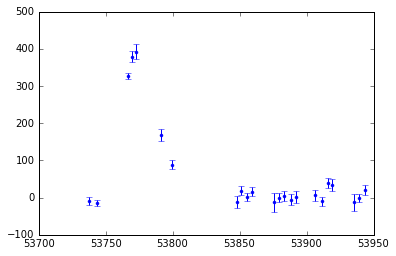

06D3cb


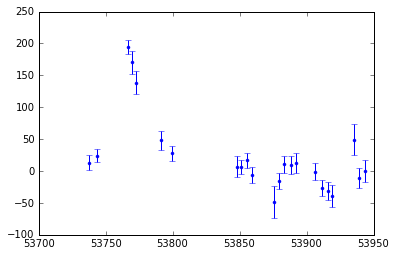

06D3cc


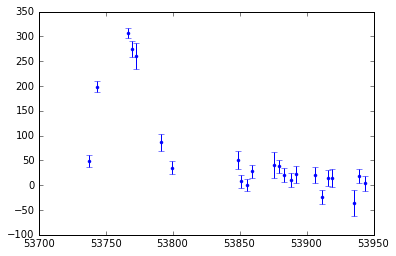

06D3cn


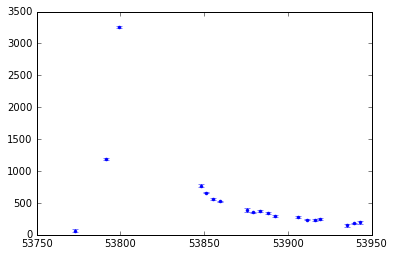

06D3df


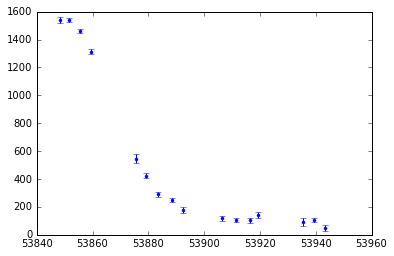

06D3dl


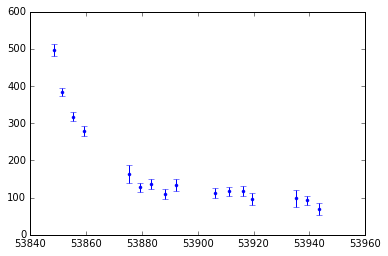

06D3do


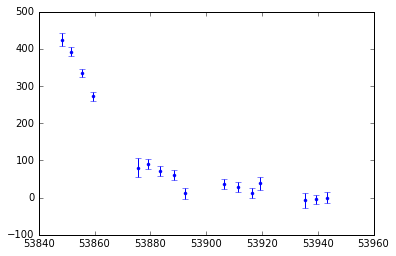

06D3dt


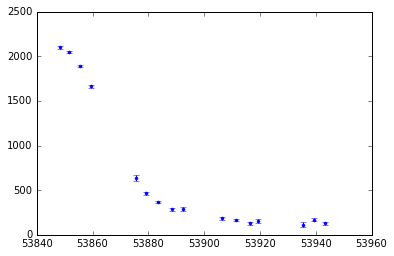

06D3ed


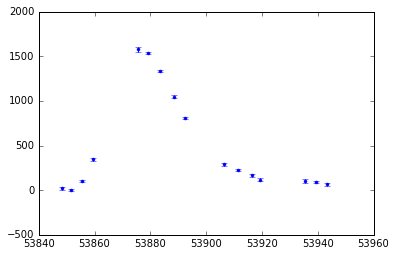

06D3el


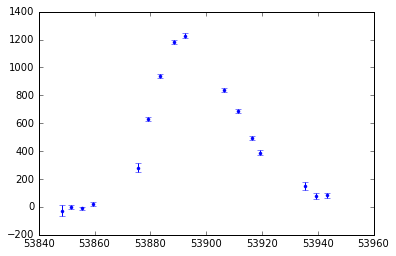

06D3em


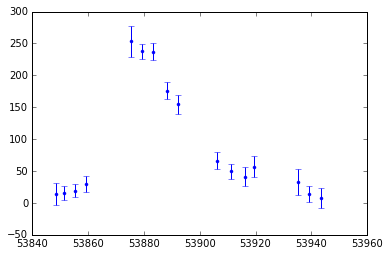

06D3en


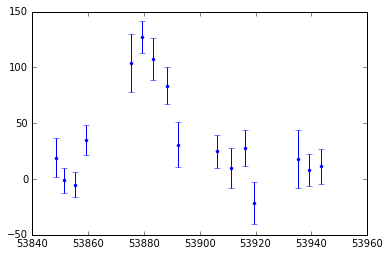

06D3et


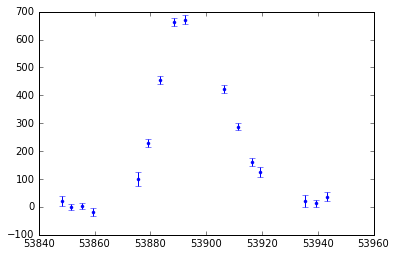

06D3fp


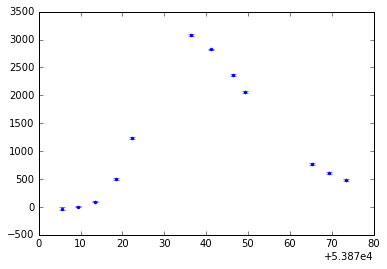

06D3gh


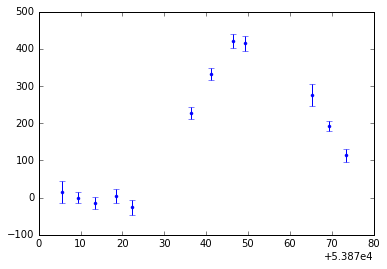

06D3gn


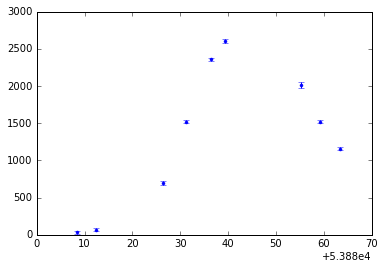

06D3gx


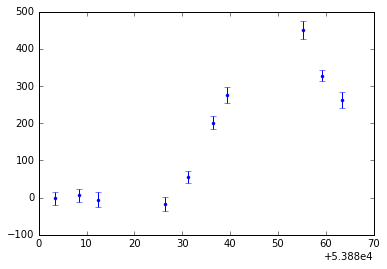

('06D3gx', '14 17 03.234 +52 56 10.510')


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    print sn[0]
    snls_lc = build_light_curve_from_snls_file(m, c)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    snls_array.append(snls_lc)
    plt.show()
    
pickle.dump(snls_array, open('/renoir_data_02/jpreyes/lsst_data/transients_files/snls_transients_filter_r.lc', 'wb'))
print sn

In [23]:
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|(.*?)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)
    break
    
print sn[0]
print m


03D1ar
[('g', '52880.58', ' 1.3035E+01', '5.4246E+00'), ('i', '52881.50', ' 1.6157E+01', '1.8629E+01'), ('r', '52881.54', ' 7.0282E+00', '9.9105E+00'), ('z', '52881.56', ' 2.2086E+01', '7.1951E+01'), ('i', '52886.60', ' 1.8944E+02', '1.9855E+01'), ('g', '52900.50', ' 1.4280E+02', '1.4970E+01'), ('i', '52900.53', ' 6.5402E+02', '2.3202E+01'), ('r', '52900.56', ' 4.5705E+02', '1.6919E+01'), ('z', '52900.59', ' 5.7204E+02', '8.9594E+01'), ('i', '52904.53', ' 6.9411E+02', '1.7710E+01'), ('r', '52904.57', ' 3.9937E+02', '1.2907E+01'), ('g', '52904.60', ' 1.1473E+02', '7.5546E+00'), ('g', '52908.53', ' 8.4923E+01', '7.5163E+00'), ('r', '52908.56', ' 3.8457E+02', '1.2797E+01'), ('i', '52908.60', ' 6.0466E+02', '2.0464E+01'), ('z', '52909.61', ' 6.6974E+02', '8.0965E+01'), ('i', '52912.49', ' 5.7083E+02', '1.9573E+01'), ('r', '52914.57', ' 2.0934E+02', '2.1674E+01'), ('i', '52915.62', ' 5.0601E+02', '2.5140E+01'), ('r', '52916.46', ' 2.7066E+02', '1.2909E+01'), ('i', '52929.44', ' 2.7509E+02',

In [9]:
matches = []
for sn in elems:
    match = False
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    
    for i, lc in enumerate(lcs):
        #print lc[0]['ra']
        #print lc[0]['dec']
        if source_distance(lc[0], {'ra':c.ra.radian, 'dec':c.dec.radian}) < 2:
            match = True
 
            matches.append((sn[0], i))
            break
    
        #print 'no match'
print 'found ' + str(float(len(matches))/float(len(elems))) 

found 0.705882352941


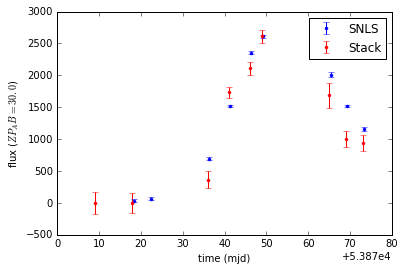

In [11]:
match = matches[11]
m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

snls_lc = build_light_curve_from_snls_file(m, c)
plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue', label='SNLS')



lc = lcs[match[-1]]  
lc_copy = lc.copy()
lc_copy.remove_row(0)


#print lc, lc_copy
m_mjd, m_f, m_e = mean_lc_flux(lc_copy)

factor = max(snls_lc['flux']) / max(m_f)
f_mf = np.multiply(m_f, factor)
f_me = np.multiply(m_e, factor)
plt.xlabel('time (mjd)')
plt.ylabel('flux ($ZP_AB=30.0$)')
plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red', label='Stack')
plt.legend(numpoints=1)
plt.show()

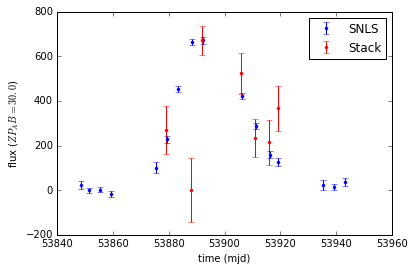

In [12]:
match = matches[9]
m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

snls_lc = build_light_curve_from_snls_file(m,c)
plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue', label='SNLS')



lc = lcs[match[-1]]  
lc_copy = lc.copy()
lc_copy.remove_row(-1)


#print lc, lc_copy
m_mjd, m_f, m_e = mean_lc_flux(lc_copy)

factor = max(snls_lc['flux']) / max(m_f)
f_mf = np.multiply(m_f, factor)
f_me = np.multiply(m_e, factor)
plt.xlabel('time (mjd)')
plt.ylabel('flux ($ZP_AB=30.0$)')
plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red', label='Stack')
plt.legend(numpoints=1)
plt.show()

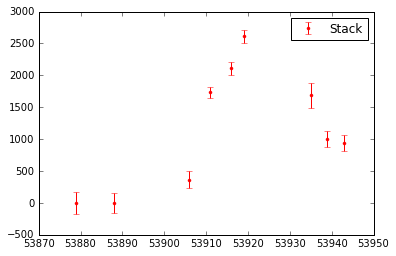

In [464]:
match = matches[-1]
m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

snls_lc = build_light_curve_from_snls_file(m)


#f = plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue', label='SNLS')
 


lc = lcs[match[-1]]  
lc_copy = lc.copy()
lc_copy.remove_row(0)


#print lc, lc_copy
m_mjd, m_f, m_e = mean_lc_flux(lc_copy)

factor = max(snls_lc['flux']) / max(m_f)
f_mf = np.multiply(m_f, factor)
f_me = np.multiply(m_e, factor)

p = plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red', label='Stack')

ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

plt.legend(numpoints=1)

plt.show()

06D3bz


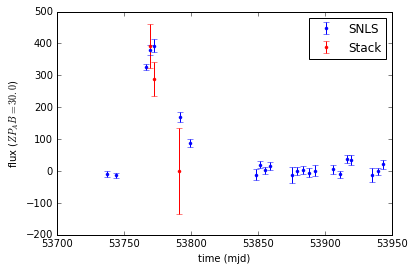

06D3cn


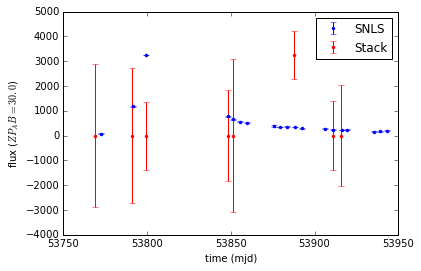

06D3df


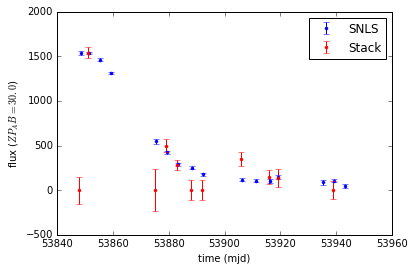

06D3dl


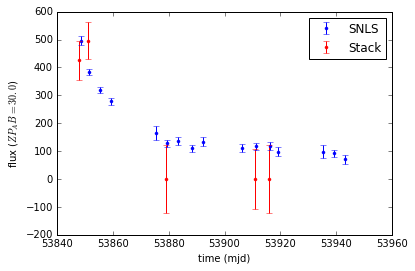

06D3do


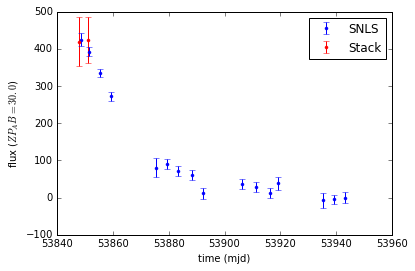

06D3dt


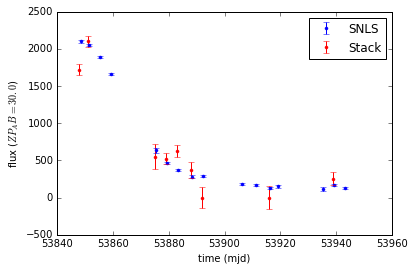

06D3ed


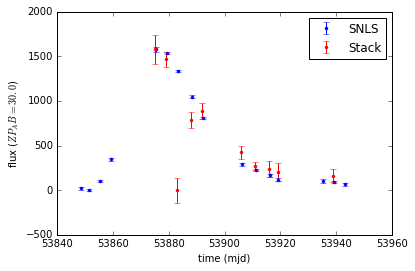

06D3el


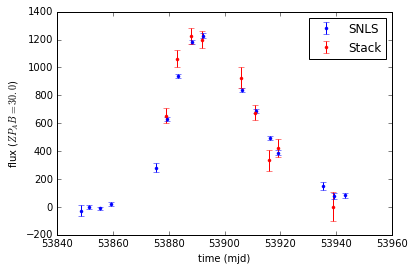

06D3em


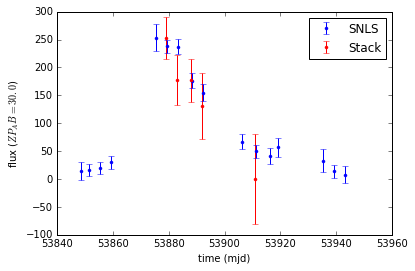

06D3et


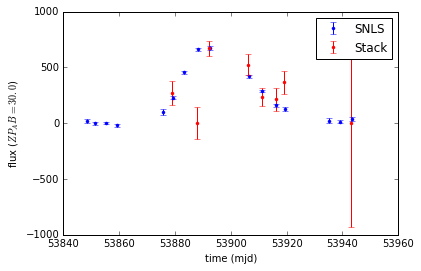

06D3fp


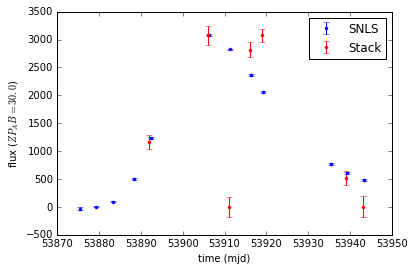

06D3gn


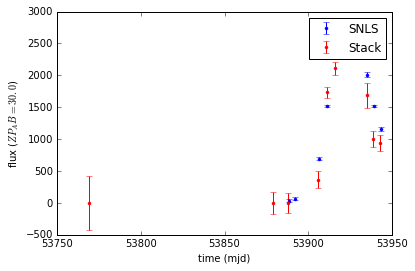

In [13]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
snls_light_curves = []

for match in matches:
    print match[0]
    m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)
   
    snls_lc = build_light_curve_from_snls_file(m, c)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue', label='SNLS')
    
    
    
    lc = lcs[match[-1]]   
    m_mjd, m_f, m_e = mean_lc_flux(lc)
    
    factor = max(snls_lc['flux']) / max(m_f)
    f_mf = np.multiply(m_f, factor)
    f_me = np.multiply(m_e, factor)
    
    plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red', label='Stack')
    plt.xticks
    
    plt.xlabel('time (mjd)')
    plt.ylabel('flux ($ZP_AB=30.0$)')
    
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.legend(numpoints=1)
    plt.show()

In [29]:

f2 = open('/renoir_data_02/jpreyes/lsst_data/sn_control/magnitude.txt','r')
data_l = f2.readlines()

In [49]:
magnitudes = {}
for line in data_l:
    values = line.split("\t")
    if values[0] != "name" and values[0].startswith("06D3"):
        magnitudes[values[0]] = float(values[-1])

In [51]:
magnitudes
magnitudes['06D3cb'] = 24.392
print magnitudes

{'06D3ed': 22.602742, '06D3gx': 23.906693, '06D3df': 22.663818, '06D3el': 22.873755, '06D3em': 24.378431, '06D3en': 24.70787, '06D3do': 23.896775, '06D3bz': 23.946563, '06D3et': 23.456685, '06D3gh': 23.914145, '06D3fp': 21.711856, '06D3cc': 24.054688, '06D3dt': 22.151638, '06D3gn': 21.864224, '06D3cb': 24.392}


In [21]:
detected = []
not_detected = []
nd_coords = []
for elem in elems:
    found = False
    m = re.findall('^'+str(elem[0])+'\\|(.*?)\\|.*?\\|.*?\\|.*?\\|.*?\\|(.*?)\\|.*?$', data_elems, re.MULTILINE)
    print elem[0]
    for match in matches:
        if match[0] == elem[0]:
            detected.append(float(m[0][-1]))
            found = True
            break
    if found == False:
        not_detected.append(float(m[0][-1]))
        nd_coords.append(m[0][0])
     

06D3bz
06D3cb
06D3cc
06D3cn
06D3df
06D3dl
06D3do
06D3dt
06D3ed
06D3el
06D3em
06D3en
06D3et
06D3fp
06D3gh
06D3gn
06D3gx


In [17]:
print len(detected) + len(not_detected)

17


In [52]:
matches

[('06D3bz', 25),
 ('06D3cn', 517),
 ('06D3df', 1040),
 ('06D3dl', 1025),
 ('06D3do', 1017),
 ('06D3dt', 1013),
 ('06D3ed', 1099),
 ('06D3el', 1114),
 ('06D3em', 1110),
 ('06D3et', 1122),
 ('06D3fp', 1138),
 ('06D3gn', 264)]

In [54]:
detected = []

undetected = []

for key in magnitudes.keys():
    det = False
    for match in matches:
        if key == match[0]:
            detected.append(magnitudes[key])
            det = True
    if det == False:
        undetected.append(magnitudes[key])

In [56]:
detected, undetected

([22.602742,
  22.663818,
  22.873755,
  24.378431,
  23.896775,
  23.946563,
  23.456685,
  21.711856,
  22.151638,
  21.864224],
 [23.906693, 24.70787, 23.914145, 24.054688, 24.392])

In [46]:
detected

[23.946563,
 22.663818,
 23.896775,
 22.151638,
 22.602742,
 22.873755,
 24.378431,
 23.456685,
 21.711856,
 21.864224]

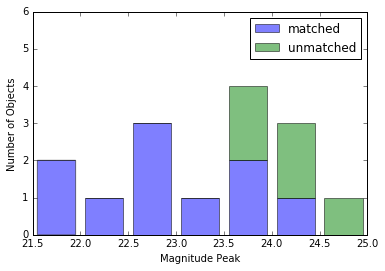

In [74]:

1.1/0.1
binwidth = .5
#plt.hist(detected, bins=np.arange(0.0,1.1+binwidth,binwidth), alpha=0.5, label="matched", stacked=True)
plt.hist([detected, undetected], bins=np.arange(21.5,25.0+binwidth,binwidth), alpha=0.5, label=['matched','unmatched'], stacked=True)
#plt.xticks(np.arange(21.0, 25.0, 0.2))
plt.yticks(np.arange(0, 7, 1))
plt.ylabel('Number of Objects')
plt.xlabel('Magnitude Peak')
#plt.xlim(xmin=0, xmax=1.1)
plt.legend(loc='upper right')
plt.show()

In [321]:
def get_diaSources_on_field(butler, visit, ccds, s_threshold=5):
    field_diaSources = []

    visit_catalog = None
    mjd = -1
    for ccd in ccds:

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}):

            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd})
            diaSrcs = butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':'r' , 'ccd':ccd})
            #print "joining ccd "+ str(ccd) + " with " + str(len(diaSrcs)) + "sources"

            fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

            m_sigma = np.mean(sigmas)
            t_sigma = s_threshold*m_sigma

            sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")
            #Here we add conditions on the DiaSources set (for instance, no diaSources with negative footprints)
            if visit_catalog == None:
                visit_catalog = diaSrcs.copy()
                visit_catalog.clear()


            for source in sources:
                 visit_catalog.addNew()
                 visit_catalog.append(source)

    #the catalog is complete
    #print "total field has " +str(len(visit_catalog)) +" sources"
    if visit_catalog is not None:
        mjd = float(diffExp.getMetadata().get("MJD-OBS"))
    return visit_catalog, mjd


In [322]:

dsrcs = butler.get('deepDiff_diaSrc', {'visit': 850177 , 'filter':'r' , 'ccd':14})


In [323]:
nd_ref = dsrcs.copy()
nd_ref.clear()
for nd in nd_coords:
    new_src = nd_ref.addNew()
    c = coord.SkyCoord(nd_coords[-1], unit=(u.hourangle, u.deg))
    new_src.setRa(afwGeom.Angle(c.ra.radian))
    new_src.setDec(afwGeom.Angle(c.dec.radian))
    nd_ref.append(new_src)
    

In [348]:
import DiaSourceTools as DSTools
import lsst.afw.table as afwTable

DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit', 'date'],dataId={'filter':'r'})
ccds = butler.queryMetadata("deepDiff_differenceExp", format=['ccd'],dataId={'filter':'r'})


catalogs = []

#ccds = [14]
cat_matches = []
for visit, date in visits:
    #if date in dates:
    #   continue
    #We check if there is actually data for the given visit (due to butler limitations) and we chose the first visit for each date
    #if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}) and date not in dates:
        #print visit
    catalog = get_diaSources_on_field(butler, visit, ccds, s_threshold=1)
    if catalog[0] is not None:
        #print catalog, nd_ref
        cat_match = afwTable.matchRaDec(nd_ref, catalog[0], afwGeom.Angle(2./3600., afwGeom.degrees))
        catalogs.append(catalog)
        cat_matches.append((visit, cat_match))

In [362]:
print t_lc['mjd']

mjd
---
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
